# Домашнее задание к лекции «Алгоритмы кластеризации»

## **Цель:**
Изучить применение моделей кластеризации

### **Описание задания:**
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

### **Этапы работы:**

#### 1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).  
a) Для отображения картинки воспользуйтесь вспомогательной функцией:  
import matplotlib.pyplot as plt  
import cv2  
import skimage  
def draw_picture(image, title, bgr=False):  
b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB  
new_image = cv2.merge([r, g, b])  
plt.figure(figsize=(7, 5))  
plt.axis(‘off’)  
plt.imshow(new_image)  
plt.title(title)  
plt.show()  
b) Для загрузки картинки можно использовать код:  
img = cv.imread(path)  

In [1]:
import cv2
import skimage
from skimage.metrics import structural_similarity as ssim

In [2]:
import pandas as pd
import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

#%config InlineBackend.figure_format = 'retina'
#from pylab import rcParams
#rcParams['figure.figsize'] = (12, 9)

In [4]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # by default cv2 works with BGR order instead of RGB
    new_img = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_img)
    plt.title(title)
    plt.show()

In [5]:
image_org = cv2.imread('C://Users//grebe//Pictures//picture.webp')

In [6]:
image_org.shape

(743, 940, 3)

In [7]:
img = cv2.resize(image_org, (128, 128)) # reduced size for faster clustering

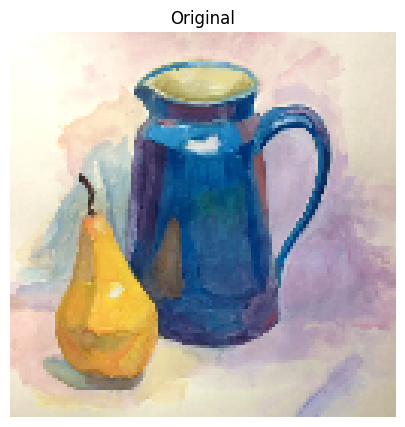

In [8]:
draw_picture(img,'Original')

In [9]:
X_train = pd.DataFrame(img.reshape((-1,3)), columns = ['B','G','R']) # transformed to dataframe

In [10]:
X_train.head()

,B,G,R
0,253,255,253
1,253,255,253
2,253,255,255
3,251,255,255
4,251,255,255


#### 2. Реализуйте три модели кластеризации:
a) [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Рассмотрите число кластеров K = 2, 5, 10, 20.  
b) [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  
c) [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Рассмотрите число кластеров K = 2, 5, 10, 20.

#### 3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

In [11]:
from sklearn.cluster import KMeans

In [12]:
def kmeans_clustering(x_train, i, r_stat):
    kmeans = KMeans(n_clusters=i, random_state=r_stat, n_init="auto").fit(x_train)
    centers = kmeans.cluster_centers_ # founded centroids
    n = centers.shape[0]
    centers = np.c_[centers, np.arange(n)] # assigned count from 0 to n
    centroids = pd.DataFrame(centers, columns =['B','G','R','N_Claster']).round().astype(np.uint8) # moved to dataframe format and one format for values
    clasters = kmeans.predict(X_train).round().astype(np.uint8) # predicted clusters numbers
    data = pd.concat([X_train,pd.DataFrame(clasters, columns=['N_Claster'])], axis=1) # moved to dataframe format
    output = pd.merge(data,centroids, how='left', on = 'N_Claster') # merged with centroids' dataframe
    b5 = output['B_y'].to_numpy().reshape((-1,128)) # chosen RGB dimension with further traansformation to required format
    g5 = output['G_y'].to_numpy().reshape((-1,128))
    r5 = output['R_y'].to_numpy().reshape((-1,128))
    return cv2.merge([b5,g5,r5])

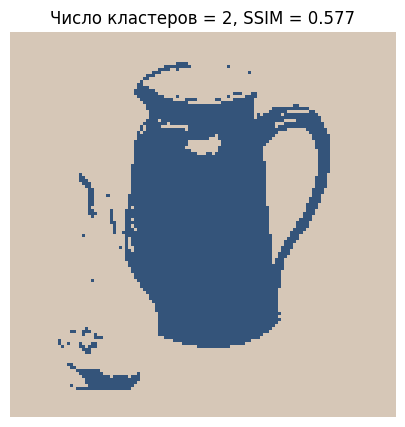

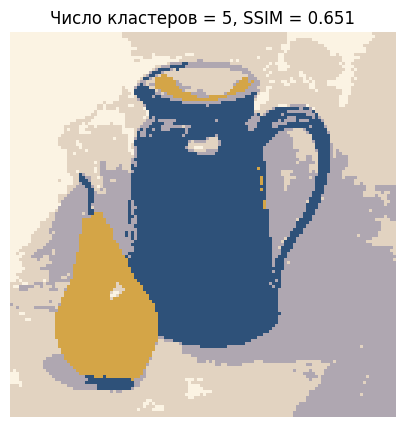

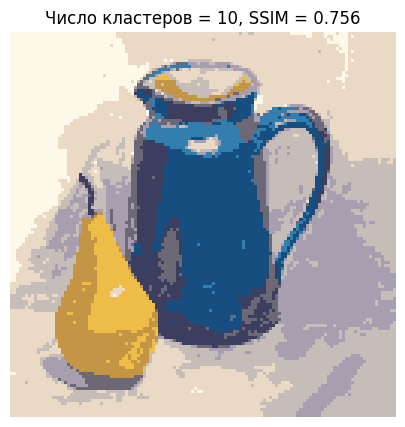

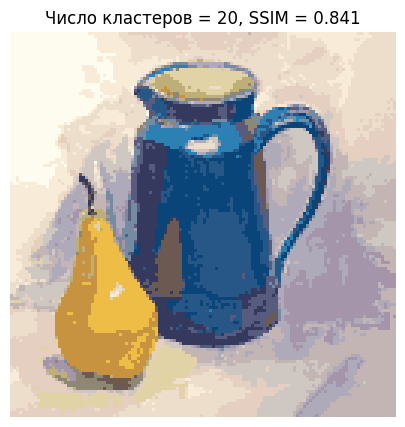

In [13]:
r_stat = 0
for i in (2,5,10,20):
    n_clusters = i
    new_test = kmeans_clustering(X_train, n_clusters, r_stat)
    acc = ssim(img, new_test, channel_axis=2)
    draw_picture(new_test, f'Число кластеров = {n_clusters}, SSIM = {acc:.3f}')

In [14]:
from sklearn.cluster import DBSCAN

In [15]:
cl_DBSCAN = DBSCAN(eps=5).fit(X_train)

In [16]:
labels = cl_DBSCAN.labels_

In [17]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 49
Estimated number of noise points: 1300


In [18]:
data = pd.concat([X_train,pd.DataFrame(labels, columns=['N_Cluster'])], axis=1)

In [19]:
data.head()

,B,G,R,N_Cluster
0,253,255,253,0
1,253,255,253,0
2,253,255,255,0
3,251,255,255,0
4,251,255,255,0


In [20]:
# поскольку центроидов в этом методе нет, то выберем центроидами средние значения
clusters_mean = data.groupby('N_Cluster', as_index=False).\
                agg({'B':'mean','G':'mean','R':'mean'}).round().astype(np.uint8)
clusters_mean.N_Cluster[0] = -1

In [21]:
output = pd.merge(data,clusters_mean, how='left', on = 'N_Cluster')

In [22]:
 # merged with centroids' dataframe
bb = output['B_y'].to_numpy().reshape((-1,128))
gg = output['G_y'].to_numpy().reshape((-1,128))
rr = output['R_y'].to_numpy().reshape((-1,128))
new_ = cv2.merge([bb,gg,rr])

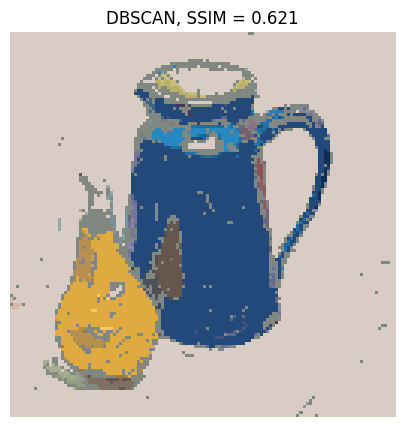

In [23]:
acc = ssim(img, new_, channel_axis=2)
draw_picture(new_, f'DBSCAN, SSIM = {acc:.3f}')

In [24]:
from sklearn.cluster import AgglomerativeClustering as AC

In [25]:
def ac_clustering(x_train, n):
    cl_AC = AC(n_clusters = n).fit(x_train)
    labels_ac = cl_AC.labels_
    data_ac = pd.concat([X_train,pd.DataFrame(labels_ac, columns=['N_Cluster'])], axis=1)
    # поскольку центроидов в этом методе нет, то выберем центроидами средние значения
    clusters_mean_ac = data_ac.groupby('N_Cluster', as_index=False).\
                agg({'B':'mean','G':'mean','R':'mean'}).round().astype(np.uint8)
    output_ac = pd.merge(data_ac,clusters_mean_ac, how='left', on = 'N_Cluster')
     # merged with centroids' dataframe
    ba = output_ac['B_y'].to_numpy().reshape((-1,128))
    ga = output_ac['G_y'].to_numpy().reshape((-1,128))
    ra = output_ac['R_y'].to_numpy().reshape((-1,128))
    return cv2.merge([ba,ga,ra])

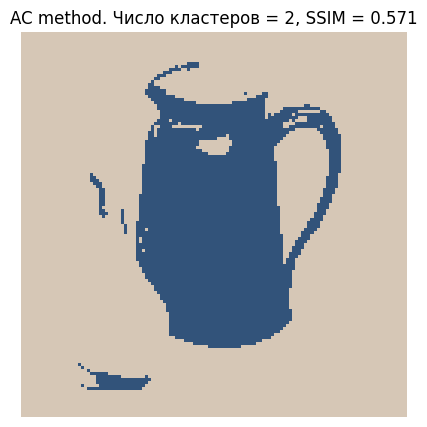

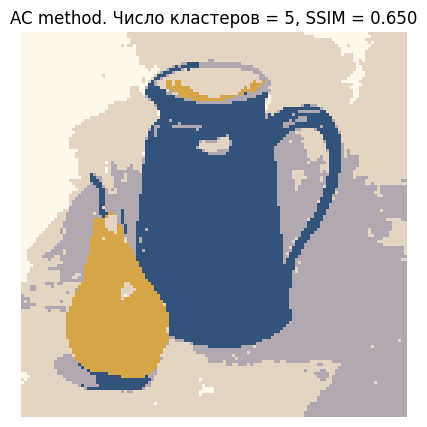

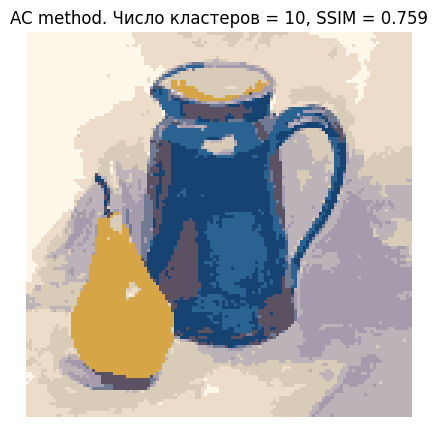

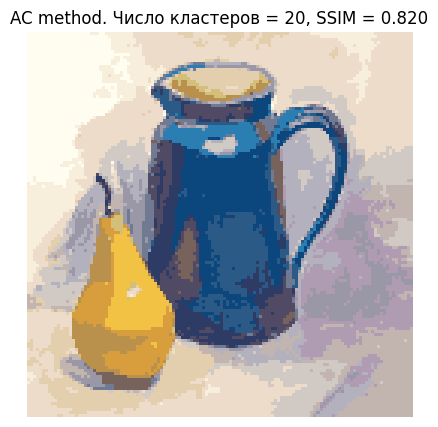

In [26]:
for i in (2,5,10,20):
    n = i
    new_ac = ac_clustering(X_train, n)
    acc = ssim(img, new_ac, channel_axis=2)
    draw_picture(new_ac, f'AC method. Число кластеров = {n}, SSIM = {acc:.3f}')

#### 4. Сформулируйте выводы по проделанной работе.  
a) Какая модель показала лучший результат?  
Для получения зачета по этому домашнему заданию минимально должно быть реализовано обучение трех моделей с одним и тем же значением кластеров, где такой параметр присутствует.

### **Ответ:** В этом конкретном случае лучший результат (SSIM = 0.841) был получен при помощи KMeans при выборе 20 кластеров.